In [1]:
import pandas as pd
import numpy as np

from scipy.sparse import hstack, csr_matrix, vstack

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn.ensemble import *
from sklearn.linear_model import *

from tqdm import *

import wordcloud
import matplotlib.pyplot as plt
import gc
%matplotlib inline

In [2]:
#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

In [3]:
import itertools
import matplotlib.gridspec as gridspec
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn  import XGBClassifier
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_decision_regions
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import catboost as cat

In [4]:
# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


(-0.5, 1439.5, 1079.5, -0.5)

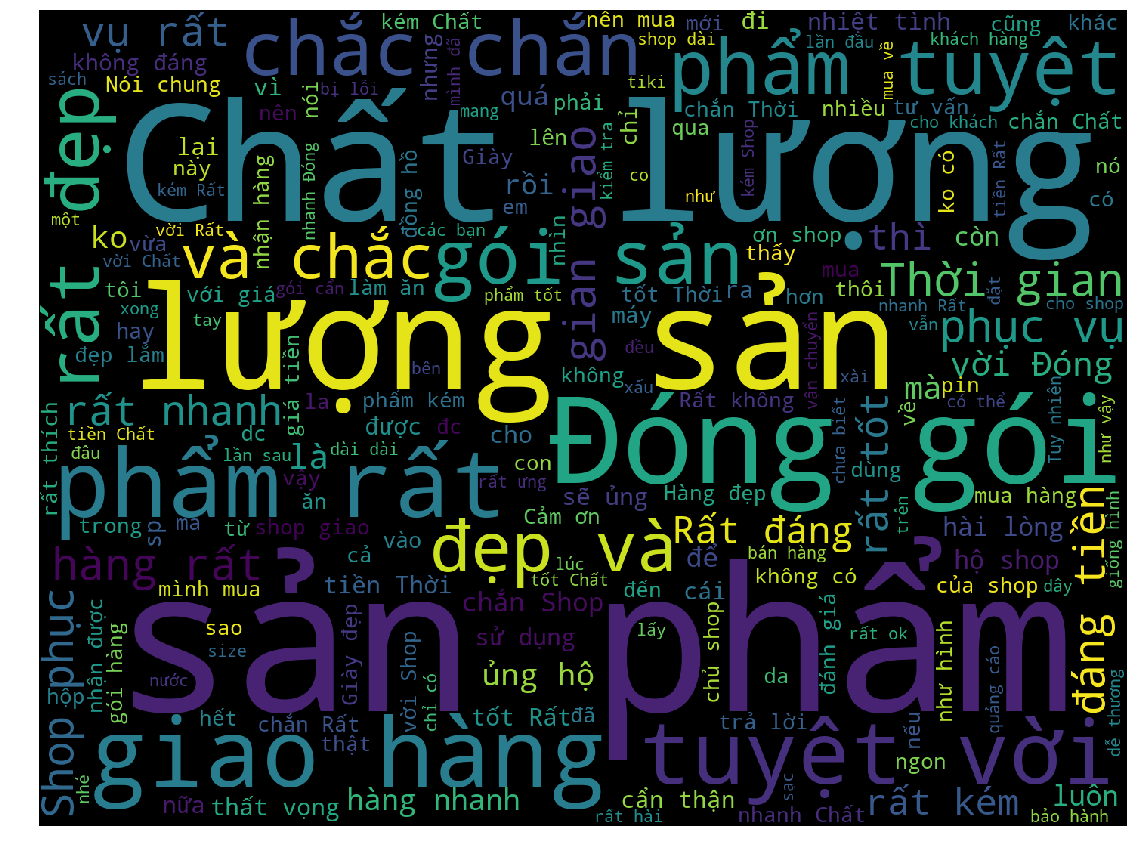

In [5]:
cloud = wordcloud.WordCloud(width=1440, height=1080).generate(" ".join(df.comment.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [6]:
import emoji

def extract_emojis(str):
    return [c for c in str if c in emoji.UNICODE_EMOJI]

In [7]:
good_df = train_df[train_df['label'] == 0]
good_comment = good_df['comment'].values
good_emoji = []
for c in good_comment:
    good_emoji += extract_emojis(c)

good_emoji = np.unique(np.asarray(good_emoji))

In [8]:
bad_df = train_df[train_df['label'] == 1]
bad_comment = bad_df['comment'].values

bad_emoji = []
for c in bad_comment:
    bad_emoji += extract_emojis(c)

bad_emoji = np.unique(np.asarray(bad_emoji))

In [9]:
good_emoji

array(['‚Üñ', '‚Üó', '‚òÄ', '‚ò∫', '‚ôÄ', '‚ô•', '‚úå', '‚ú®', '‚ùå', '‚ù£', '‚ù§', '‚≠ê', 'üÜó',
       'üåù', 'üåü', 'üåß', 'üå∑', 'üå∏', 'üå∫', 'üåº', 'üçì', 'üéà', 'üéâ', 'üêÖ', 'üêæ', 'üëâ',
       'üëå', 'üëç', 'üëè', 'üíã', 'üíå', 'üíê', 'üíì', 'üíï', 'üíñ', 'üíó', 'üíô', 'üíö', 'üíõ',
       'üíú', 'üíû', 'üíü', 'üí•', 'üí™', 'üíÆ', 'üíØ', 'üí∞', 'üìë', 'üñ§', 'üòÄ', 'üòÅ', 'üòÇ',
       'üòÉ', 'üòÑ', 'üòÖ', 'üòÜ', 'üòá', 'üòâ', 'üòä', 'üòã', 'üòå', 'üòç', 'üòé', 'üòë', 'üòì',
       'üòî', 'üòñ', 'üòó', 'üòò', 'üòô', 'üòö', 'üòõ', 'üòú', 'üòù', 'üòû', 'üòü', 'üò°', 'üò¢',
       'üò£', 'üò•', 'üò©', 'üò™', 'üò´', 'üò¨', 'üò≠', 'üòØ', 'üò∞', 'üò±', 'üò≤', 'üò≥', 'üòª',
       'üòø', 'üôÅ', 'üôÇ', 'üôÉ', 'üôÑ', 'üôÜ', 'üôå', 'ü§ë', 'ü§î', 'ü§ó', 'ü§ô', 'ü§ù', 'ü§£',
       'ü§§', 'ü§®', 'ü§™', 'ü§≠'], dtype='<U2')

In [10]:
good_emoji_fix = [
    '‚Üñ', '‚Üó', '‚òÄ', '‚ò∫', '‚ôÄ', '‚ô•', '‚úå', '‚ú®', '‚ù£', '‚ù§', '‚≠ê', 'üÜó', '^^',
       'üåù', 'üåü', 'üåß', 'üå∑', 'üå∏', 'üå∫', 'üåº', 'üçì', 'üéà', 'üéâ', 'üêÖ', 'üêæ', 'üëâ',
       'üëå', 'üëç', 'üëè', 'üíã', 'üíå', 'üíê', 'üíì', 'üíï', 'üíñ', 'üíó', 'üíô', 'üíö', 'üíõ',
       'üíú', 'üíû', 'üíü', 'üí•', 'üí™', 'üíÆ', 'üíØ', 'üí∞', 'üìë', 'üñ§', 'üòÄ', 'üòÅ', 'üòÇ',
       'üòÉ', 'üòÑ', 'üòÖ', 'üòÜ', 'üòá', 'üòâ', 'üòä', 'üòã', 'üòå', 'üòç', 'üòé', 'üòë', 'üòì', 'üòî', 
    'üòñ', 'üòó', 'üòò', 'üòô', 'üòö', 'üòõ', 'üòú', 'üòù', 'üòû', 'üòü', 'üòØ', 'üò∞', 'üò±', 'üò≤', 'üò≥', 'üòª', 'üôÇ', 'üôÉ', 'üôÑ', 'üôÜ', 'üôå', 'ü§ë', 'ü§î', 'ü§ó',
]

In [11]:
bad_emoji

array(['‚òπ', '‚úã', '‚ùå', '‚ùì', '‚ù§', '‚≠ê', 'üéÉ', 'üëå', 'üëç', 'üëé', 'üë∂', 'üíÄ', 'üíã',
       'üòÅ', 'üòÇ', 'üòà', 'üòä', 'üòå', 'üòè', 'üòê', 'üòë', 'üòí', 'üòì', 'üòî', 'üòñ', 'üòö',
       'üòû', 'üòü', 'üò†', 'üò°', 'üò¢', 'üò£', 'üò§', 'üò•', 'üòß', 'üò©', 'üò™', 'üò´', 'üò¨',
       'üò≠', 'üò≥', 'üòµ', 'üò∂', 'üôÅ', 'üôÇ', 'üôÑ', 'ü§î', 'ü§ö', 'ü§§'], dtype='<U2')

In [12]:
# Just remove "good" emoji :D
bad_emoji_fix = [
    '‚òπ', '‚úã', '‚ùå', '‚ùì', 'üëé', 'üë∂', 'üíÄ',
       'üòê', 'üòë', 'üòí', 'üòì', 'üòî', ':(', 't^t', 't ^ t',
       'üòû', 'üòü', 'üò†', 'üò°', 'üò¢', 'üò£', 'üò§', 'üò•', 'üòß', 'üò©', 'üò™', 'üò´', 'üò¨',
       'üò≠', 'üò≥', 'üòµ', 'üò∂', 'üôÅ', 'üôÑ', 'ü§î',
]

In [13]:
def count_good_bad_emoji(row):
    comment = row['comment']
    n_good_emoji = 0
    n_bad_emoji = 0
    for c in comment:
        if c in good_emoji_fix:
            n_good_emoji += 1
        if c in bad_emoji_fix:
            n_bad_emoji += 1
    
    row['n_good_emoji'] = n_good_emoji
    row['n_bad_emoji'] = n_bad_emoji
    
    return row

In [14]:
df['comment'] = df['comment'].astype(str).fillna(' ')
df = df.apply(count_good_bad_emoji, axis=1)

df['count_sent']=df["comment"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

df['words_vs_unique'] = df['count_unique_word'] / df['count_word'] * 100

In [126]:
correct_mapping = {"ad" : "admin", "bth":"b√¨nh th∆∞·ªùng", "bthg" : "b√¨nh th∆∞·ªùng", "bik" : "bi·∫øt", "bt" : "b√¨nh th∆∞·ªùng",
                   "bjo" : "bao gi·ªù", "sd" : "s·ª≠ d·ª•ng", "cx" : "c≈©ng", "cm" : "comment", "qc" : "qu·∫£ng c√°o",
                   "mik": " m√¨nh ", "haizz" : "haiz", "haizzz" : "haiz", "haizzzz" : "haiz", "ib":"inbox", "rep" : "reply",
                   "ko": "kh√¥ng", "shoppe" : "shopee", "shoppee" : "shopee", "shope" : "shopee", "shiper" : "shipper",
                   "shoo" : "shop", "tl": "tr·∫£ l·ªùi", "fb": "facebook", "face": "facebook", "spham" : "s·∫£n ph·∫©m",
                   "thanks": "c·∫£m ∆°n", "thank": "c·∫£m ∆°n", "sz" : "size", "oke" : "ok", "tg" : "tgian", "·ªßg" : "·ªßng",
                   "tks": "c·∫£m ∆°n", "tk": "c·∫£m ∆°n","sp": "s·∫£n ph·∫©m","dc": "ƒë∆∞·ª£c", "ƒëc": "ƒë∆∞·ª£c","ƒëx": "ƒë∆∞·ª£c",
                   "nhjet": "nhi·ªát","inb":"inbox", "ae" : "anh em"
}

In [127]:
corpus = df['comment']
tokenizer=TweetTokenizer()
lem = WordNetLemmatizer()
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
#    comment=re.sub('[0-9]','', comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[correct_mapping[word] if word in correct_mapping else word for word in words]
#    words=[lem.lemmatize(word, "v") for word in words]
#     words=[re.sub(r'(^r$)|(^r`$)', r'r·ªìi', word) for word in words]
#     words=[re.sub(r'(^k$)|(^kh$)', r'kh√¥ng', word) for word in words]
#     words=[re.sub(r'(^m$)', r'm√¨nh', word) for word in words]
#     words=[re.sub(r'(^mk$)', r'm√¨nh', word) for word in words]
#     words=[re.sub(r'(^au$)', r'auth', word) for word in words]
#     words=[re.sub(r'(^nc$)', r'nchung', word) for word in words]
#     words=[re.sub(r'(^nch$)', r'nchung', word) for word in words]
#     words=[re.sub(r'(^wa$)', r'qu√°', word) for word in words]

    clean_sent = " ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

clean_corpus=corpus.apply(lambda x :clean(x))

In [118]:
### Count vectorizer
tfidfvec = CountVectorizer(analyzer='word', ngram_range = (1,1), min_df = 1, max_features= 5000)

train_comments = train_df['comment'].fillna("none").values
test_comments = test_df['comment'].fillna("none").values

y_train = train_df['label'].values

X_train_tfidf = tfidfvec.fit_transform(train_comments)
X_test_tfidf = tfidfvec.transform(test_comments)

X_train = hstack([X_train_tfidf, csr_matrix(X_train_static)]).tocsr()
X_test = hstack([X_test_tfidf, csr_matrix(X_test_static)]).tocsr()

In [ ]:
char_vectorizer = TfidfVectorizer(
    min_df = 5,
    sublinear_tf=True,
    analyzer='char',
    token_pattern=r'\S',
    ngram_range=(1, 6),
    max_features=10000)
char_vectorizer.fit(clean_corpus)
features_char = np.array(char_vectorizer.get_feature_names())
train_char_features = char_vectorizer.transform(clean_corpus.iloc[:train_df.shape[0]])
test_char_features = char_vectorizer.transform(clean_corpus.iloc[train_df.shape[0]:])

In [19]:
with open('stopwords.words.txt', 'r', encoding = 'utf_8') as my_file:
    all_words = {word.strip() for word in my_file.read().split('\n')}

In [128]:
word_vectorizer = TfidfVectorizer(
    min_df = 5,
    max_df = 0.8,
    sublinear_tf=True,
    ngram_range=(1, 4),
#    stop_words = all_words,
    max_features=30000)
word_vectorizer.fit(clean_corpus)
features = np.array(word_vectorizer.get_feature_names())
train_word_features = word_vectorizer.transform(clean_corpus.iloc[:train_df.shape[0]])
test_word_features = word_vectorizer.transform(clean_corpus.iloc[train_df.shape[0]:])

In [35]:
from scipy.stats import skew

numeric_feats = df.dtypes[df.dtypes != "object"].index
# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



Skew
count_words_upper   34.086162
n_bad_emoji         32.608676
n_good_emoji        20.515688
count_punctuations  19.358625
count_sent           8.956432
count_letters        6.018465
count_word           5.932763
count_unique_word    3.806975
label                0.311152
words_vs_unique     -2.544749

In [36]:
skewness = skewness.loc[abs(skewness.Skew) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    if 'label' not in feat:
        df[feat] = boxcox1p(df[feat], lam)

There are 9 skewed numerical features to Box Cox transform


In [37]:
train_df = df.iloc[:train_df.shape[0]]
test_df = df.iloc[train_df.shape[0]:]

y_train = train_df['label'].values

In [38]:
EXCLUED_COLS = ['id', 'comment', 'label']
static_cols = [c for c in train_df.columns if not c in EXCLUED_COLS]
X_train_static = train_df[static_cols].values
X_test_static = test_df[static_cols].values

In [131]:
X_train = hstack([train_word_features, csr_matrix(X_train_static)]).tocsr()
X_test = hstack([test_word_features, csr_matrix(X_test_static)]).tocsr()

basic

In [114]:
tfidf = TfidfVectorizer(
    min_df = 5, 
    max_df = 0.8, 
    max_features=10000,
    ngram_range=(1, 4),
    sublinear_tf=True
)

train_comments = train_df['comment'].fillna("none").values
test_comments = test_df['comment'].fillna("none").values

y_train = train_df['label'].values

X_train_tfidf = tfidf.fit_transform(train_comments)
X_test_tfidf = tfidf.transform(test_comments)

X_train = hstack([X_train_tfidf, csr_matrix(X_train_static)]).tocsr()
X_test = hstack([X_test_tfidf, csr_matrix(X_test_static)]).tocsr()

## Word2vector

In [86]:
import os
import gensim

class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec

    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [87]:
w2vec = get_word2vec(
    MySentences(
        train_df['comment'].values, 
    ),
    'w2vmodel'
)

Found w2vmodel


In [88]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [89]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
trainDataVecs = mean_embedding_vectorizer.fit_transform(train_df['comment'])
testDataVecs = mean_embedding_vectorizer.fit_transform(test_df['comment'])

C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [62]:
forest = RandomForestClassifier(n_estimators = 100)
    
print("Fitting random forest to training data....")    
forest = forest.fit(trainDataVecs, train_df["label"])

result = forest.predict(testDataVecs)

Fitting random forest to training data....


In [63]:
result

array([0., 1., 0., ..., 0., 0., 0.])

In [90]:
X_train = hstack([trainDataVecs, csr_matrix(X_train_static)]).toarray()
X_test = hstack([testDataVecs, csr_matrix(X_test_static)]).toarray()

## StackNet

In [ ]:
#class GNB(self,):

def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

x = X_train
test_x = X_test

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=1.3, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

preds = np.zeros((len(test_df), 1))

label_cols = ['label']
m,r = get_mdl(train_df['label'])
preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

In [132]:
lgb1 = lgb.LGBMClassifier(max_depth=16, n_estimators=400,learning_rate=0.05,colsample_bytree=0.3,num_leaves=250,
                          metric='auc',objective='binary', n_jobs=-1)
lgb2 = lgb.LGBMClassifier(max_depth=17, n_estimators=400,learning_rate=0.05,colsample_bytree=0.3,num_leaves=120,
                          metric='f1',objective='binary', n_jobs=-1)
xgb1 = XGBClassifier(learning_rate =0.05,n_estimators=400,max_depth = 16,min_child_weight=3,gamma=0.5,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=13,
                     metric='f1')
xgb2 = XGBClassifier(learning_rate =0.04,n_estimators=400,max_depth = 15,min_child_weight=3,gamma=0.7,subsample=1,
                     colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=13,
                     metric='f1')
lr1 = LogisticRegression(C = 1.2, random_state=1)
lr2 = LogisticRegression(C = 1.3, random_state=2019)
rf1 = RandomForestClassifier (n_estimators=400, criterion="entropy", max_depth=12, max_features=0.5, random_state=3)
rf1_1 = RandomForestClassifier (n_estimators=500, criterion="entropy", max_depth=11, max_features=0.5, random_state=2019)
rf1_2 = RandomForestClassifier (n_estimators=500, criterion="entropy", max_depth=11, max_features=0.5, random_state=2)
rf2 = RandomForestClassifier(n_estimators=400, criterion="entropy", max_depth=8, max_features=0.5, random_state=1)
rf3 = RandomForestClassifier(n_estimators=500, criterion="entropy", max_depth=7, max_features=0.5, random_state=2)
et1 = ExtraTreesClassifier(n_estimators=400, criterion="entropy", max_depth=10, max_features=0.5, random_state=2, n_jobs=-1)
et2 = ExtraTreesClassifier(n_estimators=400, criterion="entropy", max_depth=7, max_features=0.5, random_state=2019, n_jobs=-1)
gbc1 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=7, max_features=0.5, random_state=1)
gbc2 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=8, max_features=0.5, random_state=2019)
dt1 = DecisionTreeClassifier(criterion='gini', max_depth=17, min_samples_split=2, max_features=0.5, random_state=1)
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=13, min_samples_split=2, max_features=0.5, random_state=5)
cat1 = CatBoostClassifier(learning_rate=0.1, iterations=400, random_seed=1, logging_level='Silent')
knn1 = KNeighborsClassifier(n_neighbors=5, leaf_size=30, p=2, n_jobs=-1) 
knn2 = KNeighborsClassifier(n_neighbors=4, leaf_size=30, p=2, n_jobs=-1) 
svm1 = svm.SVC(C = 15.0, kernel='rbf', random_state = 1)
ada1 = AdaBoostClassifier(base_estimator=None, n_estimators=400, learning_rate=0.05, algorithm='SAMME.R', random_state=1)
ada2 = AdaBoostClassifier(base_estimator=None, n_estimators=400, learning_rate=0.05, algorithm='SAMME.R', random_state=3)

#models=[[gbc1],[rf2]]
models=[[lgb1, xgb1, lr1, rf1, dt1, gbc1, rf1_1, ada1],[lgb2, xgb2, rf2, lr2, cat1, et2, gbc2, ada2, knn1, knn2],[rf3]]

In [133]:
from pystacknet.pystacknet import StackNetClassifier

model = StackNetClassifier(
    models, metric="f1", 
    folds=5,
    restacking=False, 
    use_retraining=True, 
    use_proba=True, 
    random_state=12345, n_jobs=1, verbose=1
)

model.fit(X_train, y_train)
preds=model.predict_proba(X_test) ## 893951 893741

====================== Start of Level 0 ======================
Input Dimensionality 24925 at Level 0 
8 models included in Level 0 


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Level 0, fold 1/5 , model 0 , f1===0.874600 
Level 0, fold 1/5 , model 1 , f1===0.868261 
Level 0, fold 1/5 , model 2 , f1===0.879004 
Level 0, fold 1/5 , model 3 , f1===0.830911 
Level 0, fold 1/5 , model 4 , f1===0.814888 
Level 0, fold 1/5 , model 5 , f1===0.869473 
Level 0, fold 1/5 , model 6 , f1===0.826929 
Level 0, fold 1/5 , model 7 , f1===0.842433 
=========== end of fold 1 in level 0 ===========


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Level 0, fold 2/5 , model 0 , f1===0.883274 
Level 0, fold 2/5 , model 1 , f1===0.874196 
Level 0, fold 2/5 , model 2 , f1===0.888574 
Level 0, fold 2/5 , model 3 , f1===0.845146 
Level 0, fold 2/5 , model 4 , f1===0.828744 
Level 0, fold 2/5 , model 5 , f1===0.871174 
Level 0, fold 2/5 , model 6 , f1===0.841581 
Level 0, fold 2/5 , model 7 , f1===0.850751 
=========== end of fold 2 in level 0 ===========


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Level 0, fold 3/5 , model 0 , f1===0.884418 
Level 0, fold 3/5 , model 1 , f1===0.879619 
Level 0, fold 3/5 , model 2 , f1===0.888645 
Level 0, fold 3/5 , model 3 , f1===0.838688 
Level 0, fold 3/5 , model 4 , f1===0.827514 
Level 0, fold 3/5 , model 5 , f1===0.878953 
Level 0, fold 3/5 , model 6 , f1===0.835951 
Level 0, fold 3/5 , model 7 , f1===0.859155 
=========== end of fold 3 in level 0 ===========


KeyboardInterrupt: 

In [ ]:
pred_cls = np.argmax(preds, axis=1)
pred_cls

In [121]:
submission = pd.read_csv("sample_submission.csv")
submission['label'] = pred_cls
submission.to_csv("submission.csv", index=False)

## Stacking

In [111]:
lgb1 = lgb.LGBMClassifier(max_depth=16, n_estimators=400,learning_rate=0.05,colsample_bytree=0.3,num_leaves=250,
                          metric='auc',objective='binary', n_jobs=-1)
lgb2 = lgb.LGBMClassifier(max_depth=17, n_estimators=400,learning_rate=0.05,colsample_bytree=0.3,num_leaves=120,
                          metric='f1',objective='binary', n_jobs=-1)
xgb1 = XGBClassifier(learning_rate =0.05,n_estimators=400,max_depth = 16,min_child_weight=3,gamma=0.5,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=13,
                     metric='f1')
xgb2 = XGBClassifier(learning_rate =0.04,n_estimators=400,max_depth = 15,min_child_weight=3,gamma=0.7,subsample=1,
                     colsample_bytree=0.8,objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=13,
                     metric='f1')
lr1 = LogisticRegression(C = 1.2, random_state=1)
lr2 = LogisticRegression(C = 1.3, random_state=2019)
rf1 = RandomForestClassifier (n_estimators=400, criterion="entropy", max_depth=12, max_features=0.5, random_state=3)
rf1_1 = RandomForestClassifier (n_estimators=500, criterion="entropy", max_depth=11, max_features=0.5, random_state=2019)
rf1_2 = RandomForestClassifier (n_estimators=500, criterion="entropy", max_depth=11, max_features=0.5, random_state=2)
rf2 = RandomForestClassifier(n_estimators=400, criterion="entropy", max_depth=8, max_features=0.5, random_state=1)
rf3 = RandomForestClassifier(n_estimators=500, criterion="entropy", max_depth=7, max_features=0.5, random_state=2)
et1 = ExtraTreesClassifier(n_estimators=400, criterion="entropy", max_depth=10, max_features=0.5, random_state=2, n_jobs=-1)
et2 = ExtraTreesClassifier(n_estimators=400, criterion="entropy", max_depth=7, max_features=0.5, random_state=2019, n_jobs=-1)
gbc1 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=7, max_features=0.5, random_state=1)
gbc2 = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=8, max_features=0.5, random_state=2019)
dt1 = DecisionTreeClassifier(criterion='gini', max_depth=17, min_samples_split=2, max_features=0.5, random_state=1)
dt2 = DecisionTreeClassifier(criterion='gini', max_depth=13, min_samples_split=2, max_features=0.5, random_state=5)
cat1 = CatBoostClassifier(learning_rate=0.1, iterations=400, random_seed=1, logging_level='Silent')
knn1 = KNeighborsClassifier(n_neighbors=5, leaf_size=30, p=2, n_jobs=-1) 
knn2 = KNeighborsClassifier(n_neighbors=4, leaf_size=30, p=2, n_jobs=-1) 
svm1 = svm.SVC(C = 15.0, kernel='rbf', random_state = 1)
ada1 = AdaBoostClassifier(base_estimator=None, n_estimators=400, learning_rate=0.05, algorithm='SAMME.R', random_state=1)
ada2 = AdaBoostClassifier(base_estimator=None, n_estimators=400, learning_rate=0.05, algorithm='SAMME.R', random_state=3)

In [112]:
layer1_models = [lgb1, xgb1, lr1, rf1, dt1, gbc1, rf1_1, ada1, svm1]
layer1_names = ['lgb1', 'xgb1', 'lr1', 'rf1', 'dt1', 'gbc1', 'rf1_1', 'ada1', 'svm1', 'et1']

In [100]:
oof_train = np.zeros(shape=(len(train_df),len(layer1_models)))
oof_test = np.zeros(shape=(len(test_df),len(layer1_models)))

# Recording results
layer1_score = []

In [101]:
for i in range(len(layer1_models)):
    print('\n')
    name = layer1_names[i]
    model = layer1_models[i]
    folds = KFold(n_splits=5, shuffle=True, random_state=2019)
    print('Training %s' %name)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        print('Fold no %i'%(fold_+1))
        trn_data = X_train[trn_idx]
        trn_label = y_train[trn_idx]
        val_data = X_train[val_idx]
        val_label = y_train[val_idx]
        if ('lgb' in name) or ('xgb' in name):
            model.fit(X=trn_data, y=trn_label,
                     eval_set=[(trn_data, trn_label), (val_data, val_label)],
                     verbose=200)
        else:
            model.fit(X=trn_data, y=trn_label)
        
        oof_train[val_idx,i] = model.predict(val_data)
        oof_test[:,i] += model.predict(X_test)/5
        
    score = f1_score(oof_train[:,i], y_train)
    layer1_score.append(score)
    print('Training CV score: %.5f' %score) #7603



Training lgb1
Fold no 1
[200]	valid_0's auc: 0.999999	valid_1's auc: 0.935523
[400]	valid_0's auc: 0.999999	valid_1's auc: 0.936022
Fold no 2
[200]	valid_0's auc: 1	valid_1's auc: 0.935692
[400]	valid_0's auc: 1	valid_1's auc: 0.93713
Fold no 3
[200]	valid_0's auc: 0.999999	valid_1's auc: 0.939268
[400]	valid_0's auc: 1	valid_1's auc: 0.940011
Fold no 4
[200]	valid_0's auc: 0.999999	valid_1's auc: 0.939993
[400]	valid_0's auc: 0.999999	valid_1's auc: 0.940097
Fold no 5
[200]	valid_0's auc: 0.999999	valid_1's auc: 0.934811
[400]	valid_0's auc: 0.999999	valid_1's auc: 0.936378
Training CV score: 0.84445


Training xgb1
Fold no 1
[0]	validation_0-error:0.123475	validation_1-error:0.197017
[200]	validation_0-error:0.000932	validation_1-error:0.138285
[399]	validation_0-error:0.000622	validation_1-error:0.138595
Fold no 2
[0]	validation_0-error:0.127205	validation_1-error:0.197328
[200]	validation_0-error:0.001088	validation_1-error:0.140149
[399]	validation_0-error:0.000389	validation_1-

C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold no 2


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold no 3


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold no 4


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Fold no 5


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training CV score: 0.84300


Training rf1
Fold no 1
Fold no 2
Fold no 3
Fold no 4
Fold no 5
Training CV score: 0.83637


Training dt1
Fold no 1
Fold no 2
Fold no 3
Fold no 4
Fold no 5
Training CV score: 0.74860


Training gbc1
Fold no 1
Fold no 2
Fold no 3
Fold no 4
Fold no 5
Training CV score: 0.84306


Training rf1_1
Fold no 1
Fold no 2
Fold no 3
Fold no 4
Fold no 5
Training CV score: 0.83546


Training ada1
Fold no 1
Fold no 2
Fold no 3
Fold no 4
Fold no 5
Training CV score: 0.82543


Training svm1
Fold no 1


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fold no 2


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fold no 3


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fold no 4


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Fold no 5


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Training CV score: 0.85423


In [102]:
layer2_models = [lgb2, xgb2, rf2, lr2, cat1, et2, gbc2, ada2, knn1, knn2]
layer2_names = ['lgb2', 'xgb2', 'rf2', 'lr2', 'cat1', 'et2', 'gbc2', 'ada2', 'knn1', 'knn2']

In [103]:
# Setup to record result
train_pred = np.zeros(shape=(len(train_df)))
test_pred = np.zeros(shape=(len(test_df)))

layer2_score = []

In [104]:
for i in range(len(layer2_models)):
    print('\n')
    name = layer2_names[i]
    model = layer2_models[i]
    print('Training %s' %name)
    model.fit(oof_train, y_train)
    score = f1_score(model.predict(oof_train), y_train)
    train_pred += model.predict(oof_train)/len(layer2_models)
    test_pred += model.predict(oof_test)/len(layer2_models)
    layer2_score.append(score)
    print('Training score: %.5f' % score)




Training lgb2
Training score: 0.85302


Training xgb2
Training score: 0.86025


Training rf2
Training score: 0.86350


Training lr2


C:\Users\nguyen phu hien\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training score: 0.85001


Training cat1
Training score: 0.85545


Training et2
Training score: 0.86187


Training gbc2
Training score: 0.86331


Training ada2
Training score: 0.84924


Training knn1
Training score: 0.85489


Training knn2
Training score: 0.78179


In [105]:
layer3_models = [rf3]
layer3_names = ['rf3']

train_pred3 = np.zeros(shape=(len(train_df)))
test_pred3 = np.zeros(shape=(len(test_df)))

layer3_score = []

for i in range(len(layer3_models)):
    print('\n')
    name = layer3_names[i]
    model = layer3_models[i]
    print('Training %s' %name)
    model.fit(train_pred.reshape(-1, 1), y_train)
    score = f1_score(model.predict(train_pred.reshape(-1, 1)), y_train)
    train_pred3 += model.predict(train_pred.reshape(-1, 1))/len(layer3_models)
    test_pred3 += model.predict(test_pred.reshape(-1, 1))/len(layer3_models)
    layer3_score.append(score)
    print('Training score: %.5f' % score)




Training rf3
Training score: 0.86180


In [107]:
np.round(test_pred3).astype(int)

array([0, 1, 0, ..., 0, 0, 0])

In [108]:
submission = pd.read_csv("sample_submission.csv")
submission['label'] = np.round(test_pred3).astype(int)
submission.to_csv("submission.csv", index=False)

In [ ]:
from sklearn.model_selection import cross_val_predict
models = [
    RandomForestClassifier (n_estimators=300, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
    ExtraTreesClassifier (n_estimators=300, criterion="entropy", max_depth=5, max_features=0.5, random_state=1),
    GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, max_features=0.5, random_state=1),
    LogisticRegression(random_state=1)
]

def cross_val_and_predict(clf, X, y, X_test, nfolds):
    kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=42)
    
    oof_preds = np.zeros((X.shape[0], 2))
    sub_preds = np.zeros((X_test.shape[0], 2))
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        
        clf.fit(X_train, y_train)
        
        oof_preds[valid_idx] = clf.predict_proba(X_valid)
        sub_preds += clf.predict_proba(X_test) / kf.n_splits
        
    return oof_preds, sub_preds

sub_preds = []

for clf in models:
    oof_pred, sub_pred = cross_val_and_predict(clf, X_train, y_train, X_test, nfolds=5)
    oof_pred_cls = oof_pred.argmax(axis=1)
    oof_f1 = f1_score(y_pred=oof_pred_cls, y_true=y_train)
    
    print(clf.__class__)
    print(f"F1 CV: {oof_f1}")
    
    sub_preds.append(sub_pred)

sub_preds = np.asarray(sub_preds)
sub_preds = sub_preds.mean(axis=0)
sub_pred_cls = sub_preds.argmax(axis=1)

In [ ]:
a = np.where((np.round(preds.ravel()) + sub_pred_cls + pred_cls) >= 2, 1, 0)

Parameters tuning

In [28]:
# Create parameters to search
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

gridParams = {
    'max_depth':[10, 15, 20, 25],
    'learning_rate': [0.02, 0.04, 0.05, 0.06],
    'n_estimators': [500, 600],
    'num_leaves': [80],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [1], # Updated from 'seed'
    'colsample_bytree' : [0.65],
    'subsample' : [0.75],
    'reg_alpha' : [1],
    'reg_lambda' : [1],
    'metric':['f1']
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = -1, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=-1)
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.05, 'max_depth': 10, 'metric': 'f1', 'n_estimators': 600, 'num_leaves': 80, 'objective': 'binary', 'random_state': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.75}


In [75]:
# A parameter grid for XGBoost
params = {
        'max_depth': [16, 18, 20, 22]
        }

xgb1 = XGBClassifier(learning_rate =0.05,n_estimators=300,max_depth = 16,min_child_weight=3,gamma=0.5,subsample=0.8,
                     colsample_bytree=0.8,objective= 'binary:logistic',nthread=1,scale_pos_weight=1,seed=13,
                     metric='f1')

folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

grid = GridSearchCV(estimator=xgb1, param_grid=params, scoring='f1', n_jobs=5, cv=skf.split(X_train,y_train), verbose=1 )

grid.fit(X_train, y_train)

print('\n Best hyperparameters:')
print(grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 38.2min finished



 Best hyperparameters:
{'max_depth': 17}
